In [1]:
import pandas as pd
import yfinance as yf
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
import os
import sys
import plotly
import plotly.graph_objs as go

## Automated portfolio system
### Currently generates a equally weighted portfolio that has increased by 57.28% since the completion of this project.
### And enhances the portfolio with optimized weights, outputting the final portfolio that has increased by 70.59% since the completion of this project.
### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


#### Project premise is to use an alpha generator to automatically generate a portfolio that will maximize our gains with respect to risk-taken.
#### An alpha generator is any security that, when added by an investor to an existing portfolio of assets, generates excess returns or returns higher than a pre-selected benchmark without additional risk.
#### I am using the price momentum alpha generator because its calculations are free and easily accessible through yfinance library.

### The SP500 is our benchmark, we retrieve its updated 500 stocks directly from the daily-updated csv from the State Street Global Advisors website.

In [2]:
# Get the list of S&P 500 constituents
sp500_tickers = pd.read_excel(
    "https://www.ssga.com/us/en/intermediary/etfs/library-content/products/fund-data/etfs/us/holdings-daily-us-en-spy.xlsx",
    header=4).Ticker.dropna().to_list()

# Retrieve historical data
df = yf.download(sp500_tickers, period='10y')
sp500 = df['Adj Close'].dropna(how='all', axis=1)

[*********************100%%**********************]  504 of 504 completed

3 Failed downloads:
['-', 'BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=10y)')


In [3]:
# Gets the last date of dataset
# This is our most current price for eah asset, just as a refernce of the prices we are using.
sp500.tail(1) 

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-04,144.070007,14.255,171.774994,173.940002,162.268707,111.300003,92.470001,337.320007,498.040009,198.259995,...,269.980011,35.09,109.330002,54.0,119.360001,129.554993,137.889999,129.675003,298.984985,167.595001


In [4]:
# Changing the time period and lag will affect the range of the alortithm
time_period = 1260  # 5 years of trading days. (252 trading days per year)
lag = 20 # lag of 20 trading days (1 month)


## Momentum Factors
####  Calculates each sp500 stock scores based on factors.

In [5]:
#how_many_days_back = 0 for current, 1260 for 5 years.

def calculate_momentum_factors(how_many_days_back):
# Define the start and end points for the data slice
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    
    lagged_closed_price = sp500[-start_time: -most_current_time ] #slice the dataframe to get 5 years
    rolling_mean_price = lagged_closed_price.rolling(window= time_period-251).mean().dropna(how='all') # get the rolling mean price window for 1 year

    # Calculate the 52-week trend
    slope_info = pd.DataFrame(index=sp500.columns)
    for i in range(1, lag + 1): 
        slope_info[i] = rolling_mean_price.apply(
            lambda x: np.polyfit(
                np.arange(len(x[-i - 252: -i])),
                                  x[-i - 252: -i], 1)[0] if x[-i - 252: -i].notna().all() else np.nan) 
    
    _52_week_trend = slope_info.mean(axis=1) # This is our first factor, the 52 week trend line which is the average of the slopes of the 52 week trend line


    # percent above 260 day low is the current price - 260 day low / 260 day low * 100, its used to measure the strength of the current price
    percent_above_260 = (lagged_closed_price - lagged_closed_price.rolling(window=260).min()) / lagged_closed_price.rolling(window=260).min() * 100
    percent_above_260 = percent_above_260.dropna(how='all').mean()

    # Rolling 4 week mean - rolling 52 week mean / rolling 52 week mean * 100, the oscillator is a measure of momentum
    oscillator = (lagged_closed_price.rolling(window=4*5).mean() - lagged_closed_price.rolling(window=52*5).mean()) / lagged_closed_price.rolling(window=52*5).mean() * 100
    oscillator = oscillator.dropna(how='all').mean()    

    # percent change of the adjusted close price over 39 weeks
    returns_39w = lagged_closed_price.pct_change(periods= 39 * 5).dropna(how='all').mean() 
    

    # 51 week Volume Price Trend
    volume = df['Volume'].dropna(how='all', axis=1)[-lag - time_period: -lag]
    vpt = (volume * lagged_closed_price.pct_change()).cumsum() # volume price trend is the cumulative sum of volume * pct_change 
    vpt_51w = (vpt - vpt.shift(periods=51 * 5)).dropna(how='all').mean()
    # the shift is used to shift the df by 51 weeks so that we can calculate the difference between the current and prior 51 week period 
    

    # Creating the DataFrame
    new_table = pd.DataFrame(index=sp500.transpose().index)
    new_table['Slope 52 Week Trend-Line'] = _52_week_trend
    new_table['Percent above 260 Day Low'] = percent_above_260
    new_table['4/52 Week Oscillator'] = oscillator
    new_table['39_Week_Return'] = returns_39w
    new_table['51 Week Volume Price Trend'] = vpt_51w
    return new_table

## Momentum factors Result


In [6]:
momentum_factors = calculate_momentum_factors(0)
momentum_factors

,Slope 52 Week Trend-Line,Percent above 260 Day Low,4/52 Week Oscillator,39_Week_Return,51 Week Volume Price Trend
Ticker,,,,,
A,0.047637,38.388766,6.333889,0.129354,1.385356e+05
AAL,-0.014948,45.291706,-6.695937,-0.040990,9.214214e+07
AAPL,0.125608,56.665823,13.882561,0.295647,2.998229e+07
ABBV,0.081248,39.030004,10.044563,0.184401,-6.636993e+05
ABNB,NaN,35.823103,-3.916856,-0.016898,1.599163e+06
...,...,...,...,...,...
XYL,0.027517,41.052818,4.521424,0.100898,-3.260240e+05
YUM,0.028857,36.429533,3.526406,0.067078,5.875645e+04
ZBH,-0.001229,33.114586,-0.824134,0.019227,-1.125447e+05


In [7]:
# Path
excel_file_path = 'resources/momentum_factors.xlsx'

# Save the DataFrame to Excel
momentum_factors.to_excel(excel_file_path, index=True)

## Z-Score normalizes the data results
### Our portfolio basket is determined by the highest and lowest scores, resulted from the momentum factor calculations.

In [8]:
def calculate_z_scores(x): # where x is equal to momentum_factors
    z_scores = (x - x.mean()) / x.std() # standard z score formula
    z_scores = z_scores.sum(axis=1) # summing the z-scores of each factor to get the total z-score per asset
    # The z-score is the number of standard deviations away from the mean a data point is.
    return z_scores.sort_values(ascending=False) # sorts the z-scores in descending order

long_basket = calculate_z_scores(momentum_factors)[:10] # selects the top 10 z-scores
short_basket = calculate_z_scores(momentum_factors)[-10:] # selects the bottom 10 z-scores

# basket_df = pd.DataFrame({'Long Basket': long_basket, 'Short Basket': short_basket})

# # Display the DataFrame
# print(basket_df)

print("Long Basket:")
print(long_basket)
print("\nShort Basket:")
print(short_basket)

def get_lagged_closed_price(how_many_days_back):
    start_time = how_many_days_back+ time_period + lag # start at start_time, increase by time_period, include lag
    most_current_time = how_many_days_back+ lag # only difference is the time_period is not included, so we get slice of time period exactly
    # Calculate the rolling mean price
    lagged_closed_price = sp500[-start_time: -most_current_time ]
    return lagged_closed_price

lagged_closed_price = get_lagged_closed_price(0)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price = lagged_closed_price[long_basket.index]
short_lagged_closed_price = lagged_closed_price[short_basket.index]

Long Basket:
Ticker
TSLA    39.966163
MRNA    18.597425
NVDA    18.057111
SMCI    16.677861
NVR     14.921704
ENPH    13.765331
BLDR     9.587877
CMG      9.564803
AMD      9.152116
AZO      8.992147
dtype: float64

Short Basket:
Ticker
BXP    -4.878103
VZ     -4.947378
T      -5.068559
PARA   -5.260415
WBA    -5.435019
VTRS   -5.537918
ILMN   -5.605425
WBD    -6.102216
BAX    -6.176745
FIS    -6.283102
dtype: float64


## Back Test

In [9]:
# First get the momentum factors
momentum_factors_past_5y = calculate_momentum_factors(1260) # 5 years
# Then get the z-scores
long_basket_past_5y = calculate_z_scores(momentum_factors_past_5y)[:10] # selects the top 10 z-scores
short_basket_past_5y =  calculate_z_scores(momentum_factors_past_5y)[-10:] # selects the top 10 z-scores


print("Long Basket Past 5 Years:")
print (long_basket_past_5y)
print("Short Basket Past 5 Years:")
print(short_basket_past_5y)


lagged_closed_price_past_5y = get_lagged_closed_price(1260)
# Filter lagged_closed_price based on long_basket and short_basket indices
long_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[long_basket_past_5y.index]
short_lagged_closed_price_past_5y = get_lagged_closed_price(1260)[short_basket_past_5y.index]


Long Basket Past 5 Years:
Ticker
NVR     18.337104
NVDA    16.791709
AMD     16.707073
ETSY    13.771131
CZR     13.050004
NFLX    12.593614
ALGN    11.272615
PAYC    11.116922
ENPH     8.531166
AMZN     8.170074
dtype: float64
Short Basket Past 5 Years:
Ticker
F      -5.094094
BEN    -5.149806
HWM    -5.217698
CMG    -5.358876
APA    -5.362906
BBWI   -5.583080
SLB    -5.741454
MCK    -5.856923
EQT    -6.503250
GE     -6.517024
dtype: float64


## Graphing Cumulative Returns

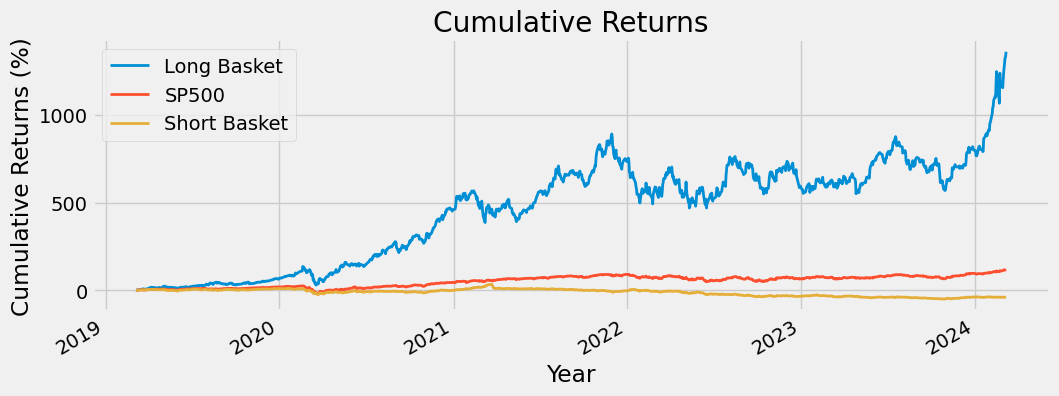

In [10]:
def calculate_cumulative_returns(dataf):
    # Calculate percentage change
    returns = dataf.pct_change()
    # Initialize the first value to 1 (i.e., no change, or 0% return)
    # This is achieved by filling the NaN values resulted from pct_change() with 0
    # and then adding 1 to convert the initial value to 1 for cumprod() calculation
    cumulative_returns = (1 + returns.fillna(0)).cumprod().mean(axis=1)*100
    # To start from 0%, subtract 100 from the entire series
    cumulative_returns = cumulative_returns - 100
    return cumulative_returns

# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns = calculate_cumulative_returns(lagged_closed_price)
long_cumulative_returns = calculate_cumulative_returns(long_lagged_closed_price)
short_cumulative_returns = calculate_cumulative_returns(short_lagged_closed_price)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns.plot(label='SP500', lw =2)
short_cumulative_returns.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Portfolio stats -- Equally weighted (not final portfolio)

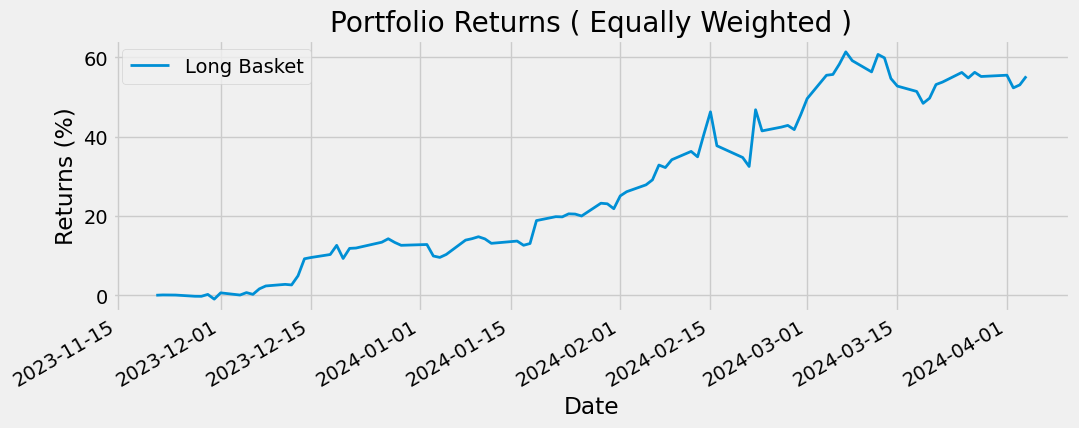

In [11]:
portfolio_returns = calculate_cumulative_returns(sp500[long_basket.index][-92:])
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
portfolio_returns.plot(label='Long Basket', lw=2) 
plt.legend()
plt.title('Portfolio Returns ( Equally Weighted )')
plt.xlabel('Date')
plt.ylabel('Returns (%)')
plt.show()

In [12]:

portfolio_returns = calculate_cumulative_returns(sp500[long_basket.index][-92:])
print("Portfolio Returns from Project Completion to Current Date:")
print (portfolio_returns)

current_date = datetime.now()
project_completion_date = datetime(2023, 11, 15)

# difference between the two dates
difference_days = current_date - project_completion_date 

# number of weeks
weeks = difference_days.days // 7
print (f"Avegare Weekly Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (portfolio_returns[-1]/weeks)

Portfolio Returns from Project Completion to Current Date:
Date
2023-11-21     0.000000
2023-11-22     0.072317
2023-11-24     0.044182
2023-11-27    -0.260559
2023-11-28    -0.274653
                ...    
2024-03-28    55.196464
2024-04-01    55.524097
2024-04-02    52.330672
2024-04-03    53.086648
2024-04-04    55.240172
Length: 92, dtype: float64
Avegare Weekly Portfolio Returns from Project Completion to Current Date (20 weeks): 
2.7620086028234936


In [13]:
print("Long Basket Cumulative Returns: Most current day")
print(long_cumulative_returns[-1])
print("Short Basket Cumulative Returns: Most current day")
print(short_cumulative_returns[-1])
print("SP500 Cumulative Returns: Most current day")
print(cumulative_returns[-1])

Long Basket Cumulative Returns: Most current day
1361.4713950796722
Short Basket Cumulative Returns: Most current day
-40.78171116191769
SP500 Cumulative Returns: Most current day
116.97212844531774


In [14]:
current_date = datetime.now().strftime("%Y-%m-%d")
print('As of',current_date,'Long Basket has outperformed the SP500 by', long_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')
print('As of',current_date, 'Short Basket has underperformed the SP500 by', short_cumulative_returns[-1] - cumulative_returns[-1], 'percentage points')


As of 2024-04-04 Long Basket has outperformed the SP500 by 1244.4992666343544 percentage points
As of 2024-04-04 Short Basket has underperformed the SP500 by -157.75383960723542 percentage points


## Graphing the Back Tested Cumulative Returns

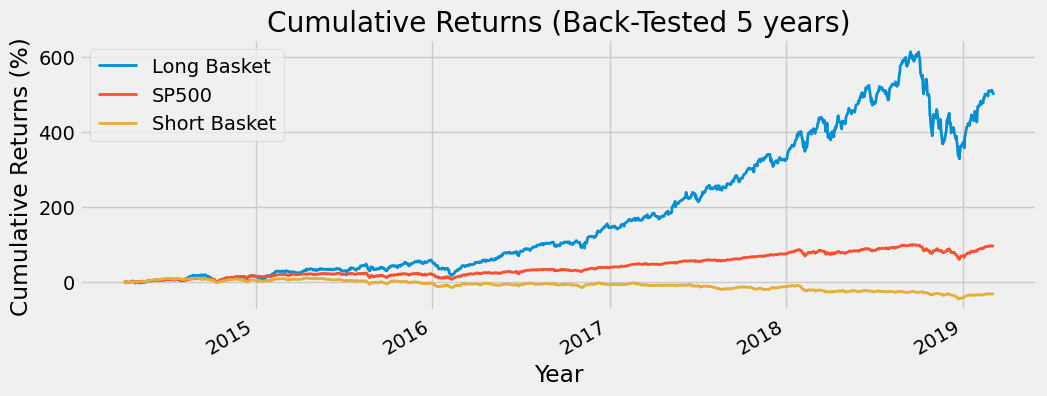

In [15]:
# Calculate the cumulative returns for the SP500, long basket, and short basket
cumulative_returns_past_5y = calculate_cumulative_returns(lagged_closed_price_past_5y)
long_cumulative_returns_past_5y = calculate_cumulative_returns(long_lagged_closed_price_past_5y)
short_cumulative_returns_past_5y = calculate_cumulative_returns(short_lagged_closed_price_past_5y)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
long_cumulative_returns_past_5y.plot(label='Long Basket', lw=2) # lw is line width
cumulative_returns_past_5y.plot(label='SP500', lw =2)
short_cumulative_returns_past_5y.plot(label='Short Basket', lw=2)

plt.legend()
plt.title('Cumulative Returns (Back-Tested 5 years)')
plt.xlabel('Year')
plt.ylabel('Cumulative Returns (%)')
plt.show()

## Monthly Potfolio Returns

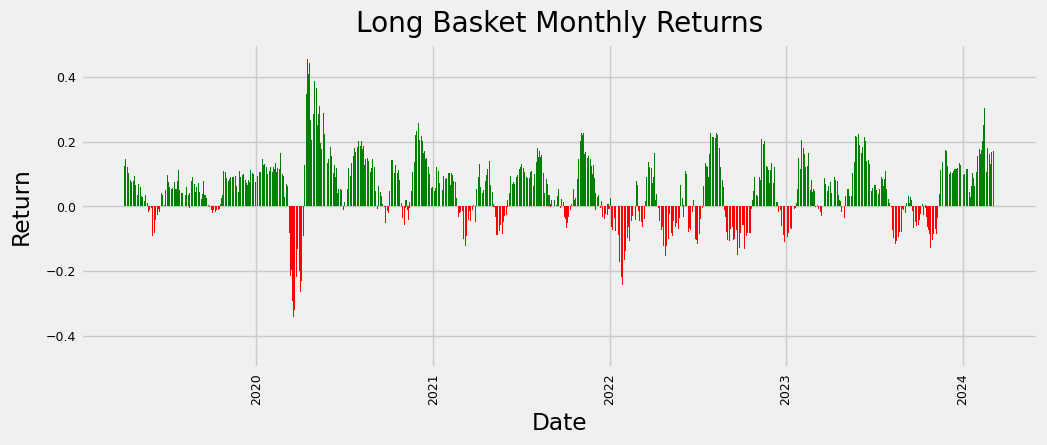

In [16]:
# Calculate 20-day returns, take the mean, drop NaNs
long_monthly_returns = long_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = long_monthly_returns.index
ydata = long_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in long_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Long Basket Monthly Returns', pad=9)
plt.show()

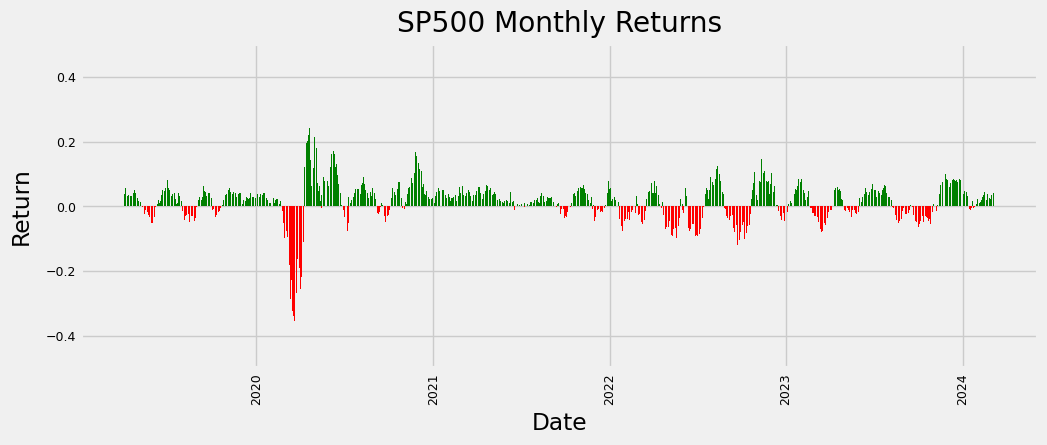

In [17]:
# Calculate 20-day returns, take the mean, drop NaNs
monthly_returns = lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = monthly_returns.index
ydata = monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('SP500 Monthly Returns', pad=9)
plt.show()

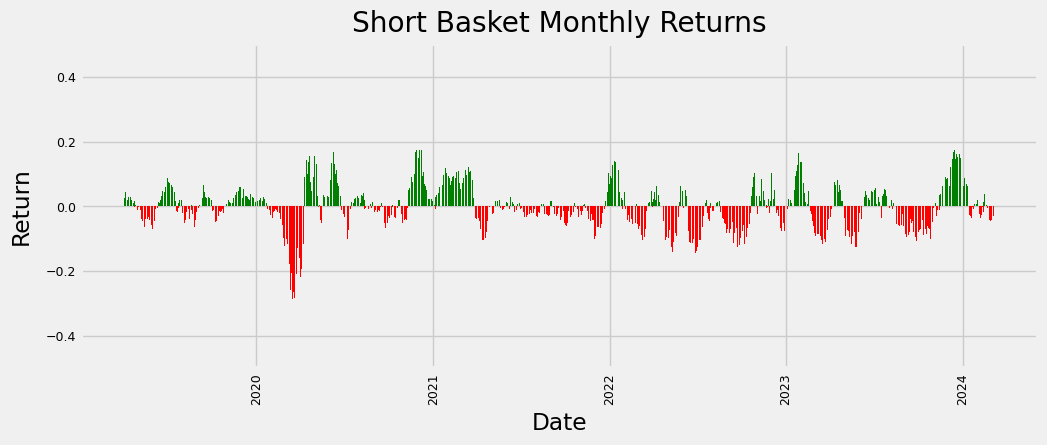

In [18]:
# Calculate 20-day returns, take the mean, drop NaNs
short_monthly_returns = short_lagged_closed_price.pct_change(20).mean(axis=1).dropna(how='all')
xdata = short_monthly_returns.index
ydata = short_monthly_returns.values
xdata = [datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S') for x in xdata]

# Plot the bar chart
plt.style.use('fivethirtyeight')
plt.figure(figsize=(11,4))
plt.bar(xdata, ydata, color=['r' if m < 0 else 'g' for m in short_monthly_returns], width=1.3)

# Customize the plot
plt.tick_params(axis='both', labelsize=9)
plt.xticks(rotation=90)
plt.ylim(-0.5, 0.5) 
plt.ylabel('Return', labelpad=9)
plt.xlabel('Date', labelpad=5)
plt.title('Short Basket Monthly Returns', pad=9)
plt.show()

## Portfolio weights : 
#### My Efficient Frontier Program takes a basket of stocks and simulates over 200,000 times to find the arrangement of stock weights for our portfolio, that will return the highest earnings over risk-level.
#### You can find this program in the directory labeled Efficient_Frontier


# Portfolio weights
## Imported class from Efficient Frontier notebook
### It runs a monte-carlo simulation to find the optimal weight based on a high return to risk ratio.

In [19]:
%%capture 
import os
import sys

# Getting the directory for the efficient frontier module: 
current_dir = os.getcwd()[:-17] # slicing out the last 14 characters (current directory)
target_dir = current_dir + 'Efficient-Frontier'

# Add the directory containing the module to the Python path
sys.path.insert(0, target_dir)

from Efficient_Frontier import EfficientFrontier

"""
Im using %%capture to suppress the output of the cell.
"""

In [20]:
ef = EfficientFrontier(sp500[long_basket.index])
print('Annual Returns: Long Basket')
ef.calculate_portfolio() #Printing Annual Returns

Annual Returns: Long Basket
Ticker
TSLA    1.401380
MRNA    1.589993
NVDA    1.638932
SMCI    1.574818
NVR     1.238177
ENPH    1.604386
BLDR    1.441694
CMG     1.223201
AMD     1.541905
AZO     1.208750
dtype: float64


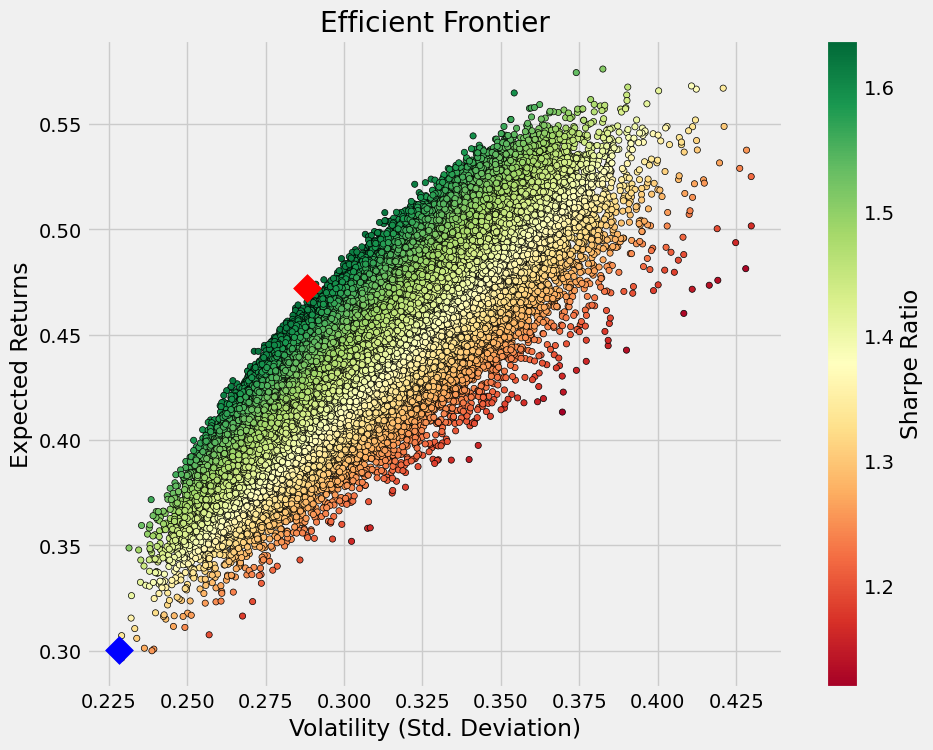

In [21]:
ef.plot_frontier() # Visualizes the simulations for our Long Basket portfolio
# With each dot representing a different portfolio, and the curve of the spread representing the efficient frontier

In [22]:
ef.get_optimal_portfolio()

              Minimum Risk Adjusted Values  Max Risk Adjusted Values
Returns                           0.300247                  0.472107
Volatility                        0.228147                  0.288288
Sharpe Ratio                      1.316022                  1.637622
TSLA Weight                       0.016393                  0.054595
MRNA Weight                       0.019550                  0.138797
NVDA Weight                       0.107469                  0.274056
SMCI Weight                       0.008690                  0.126158
NVR Weight                        0.105406                  0.010485
ENPH Weight                       0.029669                  0.042164
BLDR Weight                       0.042586                  0.067669
CMG Weight                        0.313745                  0.051286
AMD Weight                        0.006541                  0.007066
AZO Weight                        0.349951                  0.227723


## Maximizing returns with our updated weights:

In [30]:

weights_minimal_risk = {
    'TSLA': 0.051118, 'MRNA': 0.101076, 'NVDA': 0.032128, 'SMCI': 0.010970,
    'NVR': 0.293823, 'ENPH': 0.004250, 'BLDR': 0.002243, 'CMG': 0.080609,
    'AZO': 0.377251, 'AMD': 0.046532
}

weights_maximum_risk = {
    'TSLA': 0.013270, 'MRNA': 0.155588, 'NVDA': 0.250389, 'SMCI': 0.150165,
    'NVR': 0.022550, 'ENPH': 0.073423, 'BLDR': 0.019092, 'CMG': 0.022661,
    'AZO': 0.244763, 'AMD': 0.048099
}

equally_weighted = {
    'TSLA': 0.1, 'MRNA': 0.1, 'NVDA': 0.1, 'SMCI': 0.1,
    'NVR': 0.1, 'ENPH': 0.1, 'BLDR': 0.1, 'CMG': 0.1,
    'AZO': 0.1, 'AMD': 0.1
}

# Calculate daily portfolio returns for both scenarios
portfolio_returns_equally_weighted = (sp500[long_basket.index][-92:].pct_change() * pd.Series(equally_weighted)).sum(axis=1)
portfolio_returns_minimal_risk = (sp500[long_basket.index][-92:].pct_change() * pd.Series(weights_minimal_risk)).sum(axis=1)
portfolio_returns_maximum_risk = (sp500[long_basket.index][-92:].pct_change() * pd.Series(weights_maximum_risk)).sum(axis=1)

# Calculate cumulative returns to see the overall performance
cumulative_returns_equally_weighted = ((1 + portfolio_returns_equally_weighted).cumprod() - 1)*100
cumulative_returns_minimal_risk = ((1 + portfolio_returns_minimal_risk).cumprod() - 1)*100
cumulative_returns_maximum_risk = ((1 + portfolio_returns_maximum_risk).cumprod() - 1)*100


# Convert the cumulative return Series to DataFrame for easy Plotly use
cumulative_returns_maximum_risk_df = cumulative_returns_maximum_risk.reset_index()
cumulative_returns_equally_weighted_df = cumulative_returns_equally_weighted.reset_index()
cumulative_returns_minimal_risk_df = cumulative_returns_minimal_risk.reset_index()

# Create traces
trace_max_risk = go.Scatter(
    x=cumulative_returns_maximum_risk_df['Date'],  # or appropriate index name if 'Date' isn't correct
    y=cumulative_returns_maximum_risk_df[0],  # use the column name for the data if it's not the 0th column
    mode='lines',
    name='Maximum Risk Portfolio'
)

trace_equal_weight = go.Scatter(
    x=cumulative_returns_equally_weighted_df['Date'],
    y=cumulative_returns_equally_weighted_df[0],
    mode='lines',
    name='Equally Weighted Portfolio',
    line=dict(dash='dash')  # Dashed line
)

trace_min_risk = go.Scatter(
    x=cumulative_returns_minimal_risk_df['Date'],
    y=cumulative_returns_minimal_risk_df[0],
    mode='lines',
    name='Minimal Risk Portfolio'
)

# Combine the traces into a list
data = [trace_max_risk, trace_equal_weight, trace_min_risk]

# Set the layout of the figure
layout = go.Layout(
    title=go.layout.Title(
        #text='Portfolio Cumulative Returns',
        #font=dict(color='white')  # Title color
    ),
    xaxis=dict(
        title='Date',
        showgrid=False,  # Turns off the x-axis gridlines
        tickfont=dict(color='white'),  # X-axis ticks color
        title_font=dict(color='white')  # X-axis title color
    ),
    yaxis=dict(
        title='Cumulative Returns (%)',
        showgrid=False,  # Turns off the y-axis gridlines
        tickfont=dict(color='white'),  # Y-axis ticks color
        title_font=dict(color='white')  # Y-axis title color
    ),
    legend=dict(
        x=0,
        y=1.2,
        orientation='h',
        font=dict(color='white')  # Legend text color
    ),
    paper_bgcolor='rgba(0,0,0,0)',  # Keep the background transparent
    plot_bgcolor='rgba(0,0,0,0)',  # Keep the plot area background transparent
    autosize=False,
    width=900,
    height=500
)

# Create the figure
fig = go.Figure(data=data, layout=layout)

# Plot the figure
fig.show()

In [24]:
print ("Max Risk portfolio returns:")
print (cumulative_returns_maximum_risk)
print ("Min Risk portfolio returns:")
print (cumulative_returns_minimal_risk)

print (f"Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_maximum_risk[-1]/weeks)

print (f"Avegare Weekly Min Risk Portfolio Returns from Project Completion to Current Date ({weeks} weeks): ")
print (cumulative_returns_minimal_risk[-1]/weeks)



Max Risk portfolio returns:
Date
2023-11-21     0.000000
2023-11-22    -0.348742
2023-11-24    -0.655415
2023-11-27    -1.163252
2023-11-28    -1.559688
                ...    
2024-03-28    68.397991
2024-04-01    68.789573
2024-04-02    66.271948
2024-04-03    66.012780
2024-04-04    67.896179
Length: 92, dtype: float64
Min Risk portfolio returns:
Date
2023-11-21     0.000000
2023-11-22    -0.047011
2023-11-24     0.054485
2023-11-27    -1.297385
2023-11-28    -1.331858
                ...    
2024-03-28    27.939980
2024-04-01    27.729835
2024-04-02    26.208703
2024-04-03    25.978806
2024-04-04    26.209306
Length: 92, dtype: float64
Avegare Weekly Max Risk Portfolio Returns from Project Completion to Current Date (20 weeks): 
3.3948089488661624
Avegare Weekly Min Risk Portfolio Returns from Project Completion to Current Date (20 weeks): 
1.3104652834333153


In [25]:
import json

output_dir = 'C:\\Users\\jeanb\\Documents\\GitHub\\Quantative-Finance-Repo\\Berry-Cox-Baskets\\output'
os.makedirs(output_dir, exist_ok=True)

# Define the full path for the JSON file
json_file_path = os.path.join(output_dir, 'portfolio_returns.json')

# Assuming 'portfolio_returns', 'cumulative_returns_maximum_risk', 'cumulative_returns_minimal_risk', and 'weeks'
# are the variables containing the data you want to output
output_data = {
    "Portfolio 1 Returns": portfolio_returns[-1],
    "Portfolio 1 Average Weekly Returns": portfolio_returns[-1] / weeks,
    "Max Risk Portfolio Returns": cumulative_returns_maximum_risk[-1],
    "Max Risk Portfolio Average Weekly Returns": cumulative_returns_maximum_risk[-1] / weeks,
    "Min Risk Portfolio Returns": cumulative_returns_minimal_risk[-1],
    "Min Risk Portfolio Average Weekly Returns": cumulative_returns_minimal_risk[-1] / weeks,
    "Difference in E.W Portfolio and MaxRisk Portfolio": cumulative_returns_maximum_risk[-1] - portfolio_returns[-1],
    
}

# Convert the data to a JSON string
json_data = json.dumps(output_data, indent=4)

# Write the JSON data to the specified file
with open(json_file_path, 'w') as json_file:
    json_file.write(json_data)

# Confirm the path where the file was saved
print(f"File saved to {json_file_path}")

File saved to C:\Users\jeanb\Documents\GitHub\Quantative-Finance-Repo\Berry-Cox-Baskets\output\portfolio_returns.json
